In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Online feature serving BigQuery data with Vertex AI Feature Store 2.0


<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/feature_store/online_feature_serving_bigquery_data_with_feature_store_2_0.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/feature_store/online_feature_serving_bigquery_data_with_feature_store_2_0.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/feature_store/online_feature_serving_bigquery_data_with_feature_store_2_0.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>                                                                                               
</table>

## Overview

This tutorial demonstrates how to use the public Preview release of Vertex AI Feature Store 2.0. Vertex AI Feature Store 2.0 lets you online serve features with existing data in BigQuery.

### Feature Store 2.0 data model

The new approach in Feature Store 2.0 is to "bring Feature Store to your (BigQuery) data". Feature Store 2.0 provides a set of APIs that let you add online serving capabilities to your data in BigQuery. Future releases will also add feature management, search, discovery, and online-offline-consistent serving directly on BigQuery datasets.

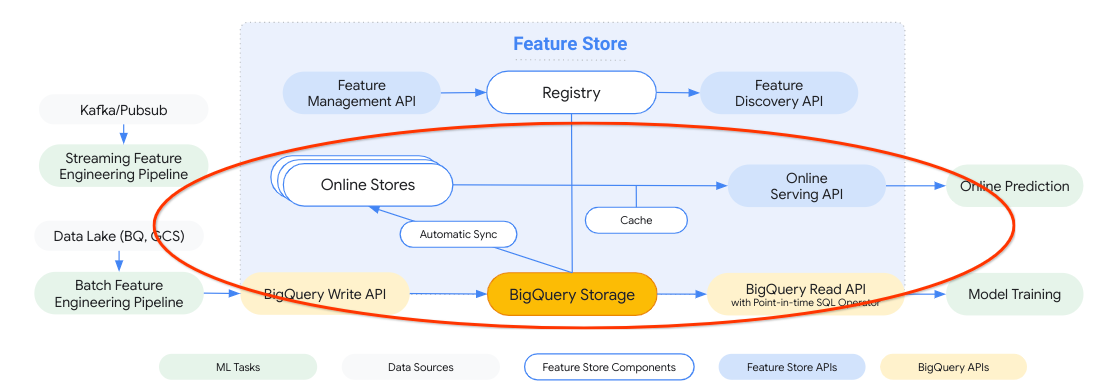

Feature Store 2.0 introduces the following new concepts:

* **Online store** (`FeatureOnlineStore`) is a feature data storage within Feature Store.

* **Feature view** (`FeatureView`) is a collection of features that constitute an instance within a `FeatureOnlineStore`. A `FeatureView` instance typically corresponds to a machine learning (ML) model for online prediction purposes.

Embedding management introduces the vector search capability to Feature Online Store, so that it can as an embedding store. Embeddings can be stored in BigQuery as a regular double array feature, and connected with Feature Store using special configurations.

### Costs

In the public Preview release, there are no charges for Feature Store resources, such as `FeatureOnlineStore` and `FeatureView`.

#### Optimize costs during sync

You can follow these general guidelines to optimize BigQuery usage costs during data sync:

* Configure the schedule not to run more frequently than the expected frequency of changes in feature data.
* Only include data that's needed for online serving.
* Avoid running complex aggregations in BigQuery. Run a `SELECT *` query on the table or view to estimate the volume and duration of data processing.
* Set `max_node_count` to a value that's high enough to cover high loads during sync.
* Within the same online store, schedule the sync for different feature views at different times.
* If your BigQuery table has extensive historical data, partition the table by timestamps and specify the time range to scan data.
* Bigtable utilization increases during sync. Schedule sync jobs during off-peak times, if possible.

### Resource usage guidelines

> Note: These guidelines are applicable during the Feature Store 2.0 public Preview release and might change in future releases.

For optimal performance, follow these guidelines during the Feature Store 2.0 public Preview release:

| Description | Recommended maximum value|
|-------|-------|
| Number of `FeatureOnlineStore` instances | 2 |
| Number of `FeatureView` instances in an online store | 10 |
| Size of feature data per entity | 10 MB |

Note that as the size of feature data increases, you might experience an increase in end-to-end latency due to network usage.


### Objective

In this tutorial, you can do the following:

1.  Provision an online store instance to host and serve data.
2.  Create online store instance to serve a BigQuery table.
3.  Use the online server to search nearest neighbors.

## Before you begin

### Enable Vertex AI API

Authenticate and enable the Vertex AI API. If you are running this colab in Vertex workbench, please run below auth commands in the terminal tab.

In [ ]:
!gcloud auth login
!gcloud config set account <your_google_account>
!gcloud services enable aiplatform.googleapis.com --project ${your-project-id}

### Set up IAM permissions

For the public Preview release, you need at least one of the following roles to use this tutorial:
* Project owner (`roles/owner`)
* Editor (`roles/editor`)


### Install Feature Store Python SDK

Optional: If you've installed a previous release of the google-cloud-aiplatform SDK, uninstall it.

In [ ]:
# Uninstall previous version of google-cloud-aiplatform SDK
!pip uninstall google-cloud-aiplatform -y

Install the Python SDK for the Feature Store 2.0.

In [ ]:
# Dowload and install the private SDK
!gsutil cp gs://staging-sdks/230828/aiplatform-v1beta1-py.tar.gz .
!pip install --user aiplatform-v1beta1-py.tar.gz
!rm aiplatform-v1beta1-py.tar.gz

#### Restart the kernel

After you install the SDK, restart the notebook kernel so it can find the packages.

In [ ]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Set up your project

Specify your project ID, location, and API endpoint, and then authenticate your account.

### Set your project ID

**If you don't know your project ID**, retrieve it using `gcloud` before proceeding.

In [ ]:
import os

PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]

print("In Python, your PROJECT_ID is", PROJECT_ID)
!echo In bash, your PROJECT_ID is $PROJECT_ID

**If you know your project ID**, set it here:

In [ ]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "your-project-id"  # @param {type:"string"}
print("In Python, your PROJECT_ID is set as", PROJECT_ID)
!echo In bash, your PROJECT_ID is set as $PROJECT_ID

### Specify project location and endpoint

Set the location and the corresponding API endpoint.

Note that the new API is only available in the following regions:
* `us-centra1`
* `us-east1`
* `us-west1`
* `europe-west4`
* `asia-southeast1`

In [ ]:
LOCATION = "us-central1"  # @param {type:"string"}
API_ENDPOINT = f"{LOCATION}-aiplatform.googleapis.com"

### Enable Vertex AI API


Run the following command to enable the Vertex AI API.

In [ ]:
!gcloud services enable aiplatform.googleapis.com --project ${your-project-id}

### Authenticate your Google Cloud account

**If you're using Google Cloud Notebooks**, your environment is already
authenticated. Skip this step.

**If you're using Colab**, authenticate your account via OAuth by running the following code, and following the instructions when prompted.

**If you're not using either Google Cloud Notebooks or Colab**, follow these instructions:

1. From the Google Cloud console, go to the [**Create service account key**
   page](https://console.cloud.google.com/apis/credentials/serviceaccountkey).

1. Click **Create service account**.

1. In the **Service account name** field, enter a name for the service account, and click **Create**.

1. Under **Grant this service account access to project**, select the following options in the **Role** drop-down list:
  * **Vertex AI Administrator**.
  * **Storage Object Admin**

  To filter the list of roles, type a few characters of the role name in the filter box above the list of options.

1. Click **Create**. A JSON file containing your key is downloaded to your local environment.

1. Enter the path to your service account key as the
`GOOGLE_APPLICATION_CREDENTIALS` variable and run the following code.

In [ ]:
import os
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your Google Cloud account. This provides access
#  to your Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# If on Google Cloud Notebooks, then don't execute this code
if not IS_GOOGLE_CLOUD_NOTEBOOK:
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your
    # Google Cloud account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

## Set up data source in BigQuery

### Requirements
The data source has to be a BigQuery table or a BigQuery view, with the following requirements on columns:
1. [*Required*] One entity id column, type: string
2. [*Required*] One embedding column, type: double array
3. [*Optional*] One or more filtering columns, type: string or string array
4. [*Optional*] One crowding column, type: integer. Crowding ensures that results are diverse by returning at most k' < k neighbors with any single crowding attribute out of k total neighbors


### Test data source

To illustrate, we'll use the [the Publications](https://pantheon.corp.google.com/marketplace/product/google_patents_public_datasets/google-patents-public-data) dataset from the BigQuery public datasets.


Select a subset and exclude the repeated records type of columns that are not compatible with Feature Store from the `patents-public-data.google_patents_research.publications_202304` table:

Create a small dataset (<=100MB) for demo purpose, you can use the full dataset if needed.

In [ ]:
FEATURE_EXTRACT_QUERY_FULL = """
SELECT publication_number, embedding_v1 as embedding, url, country, publication_description,
cpc_low, cpc_inventive_low, top_terms, title, CAST(title_translated as INT) as title_translated,
abstract, CAST(abstract_translated as INT) as abstract_translated,
cited_by[safe_offset(0)].filing_date as cited_by_filing_date,
similar[safe_offset(0)].filing_date as similar_filing_date
FROM `patents-public-data.google_patents_research.publications_202304`
"""
FEATURE_EXTRACT_QUERY_SMALL = f"{FEATURE_EXTRACT_QUERY_FULL} WHERE cited_by[safe_offset(0)].filing_date is not NULL LIMIT 1000"

This data source has some filtering columns (e.g. country) and crowding columns (e.g. cited_by_filing_date). Below is the schema of publications data table we use in this guide:

|Column name |  Type  |   Mode   |
|------------|--------|----------|
|publication_number	| STRING |	NULLABLE
|embedding |	FLOAT |	REPEATED
|url |	STRING	| NULLABLE
|country|	STRING|	NULLABLE|
|publication_description|	STRING|	NULLABLE|
|cpc_low|	STRING|	REPEATED|
|cpc_inventive_low|	STRING|	REPEATED|
|top_terms|	STRING|	REPEATED|
|title|	STRING|	NULLABLE|
|title_translated|	INTEGER|	NULLABLE|
|abstract|	STRING|	NULLABLE|
|abstract_translated|	INTEGER|	NULLABLE|
|cited_by_filing_date|	INTEGER|	NULLABLE|
|similar_filing_date|	INTEGER|	NULLABLE|

View the retrieved data.

In [ ]:
from google.cloud import bigquery

bq_client = bigquery.Client(project=PROJECT_ID)

product_data = bq_client.query(FEATURE_EXTRACT_QUERY_SMALL).result().to_dataframe()

print(product_data.shape)
product_data.head()

### Create BigQuery dataset

Create a BigQuery dataset to hold the BigQuery table for the demo. Since the source data for this demo is located in the `US` region, the dataset must also be located in the `US` region. If you use your own data and dataset, you can also use that dataset to create the BigQuery table.


In [ ]:
# First, create a dataset if it does not already exist. The source data for this demo is located in the US region, so the dataset must also be located in the US region.

BQ_DATASET_ID = "featurestore_demo"  # @param {type:"string"}
dataset = bigquery.Dataset(f"{PROJECT_ID}.{BQ_DATASET_ID}")
dataset.location = "US"
dataset = bq_client.create_dataset(
    dataset, exists_ok=True, timeout=30
)  # Make an API request.
# Confirm dataset created.
print(f"Created dataset {dataset}.{BQ_DATASET_ID}")

Create 1 BigQuery table.

In [ ]:
# Now, create the table

BQ_TABLE_ID = "publications_202304_small"  # @param {type:"string"}
BQ_TABLE_ID_FQN = f"{PROJECT_ID}.{BQ_DATASET_ID}.{BQ_TABLE_ID}"
job_config = bigquery.QueryJobConfig(destination=BQ_TABLE_ID_FQN)
query_job = bq_client.query(FEATURE_EXTRACT_QUERY_SMALL, job_config=job_config)
query_job.result()

print(f"Created table: {BQ_TABLE_ID_FQN}")

In [ ]:
DATA_SOURCE = f"bq://{BQ_TABLE_ID_FQN}"
print(f"Data source is: {DATA_SOURCE}")

## Set up and start online serving

To serve embedding data in Feature Store 2.0, you need to do the following:

1. Create an online store cluster to host the data.
2. Define the data (FeatureView) to be served by the newly-created instance.

### Initialize Admin Service Client

Load the Feature Store 2.0 SDK.

In [ ]:
from google.cloud.aiplatform_v1beta1 import (
    FeatureOnlineStoreAdminServiceClient, FeatureOnlineStoreServiceClient)
from google.cloud.aiplatform_v1beta1.types import \
    feature_online_store as feature_online_store_pb2
from google.cloud.aiplatform_v1beta1.types import \
    feature_online_store_admin_service as \
    feature_online_store_admin_service_pb2
from google.cloud.aiplatform_v1beta1.types import \
    feature_online_store_service as feature_online_store_service_pb2
from google.cloud.aiplatform_v1beta1.types import \
    feature_view as feature_view_pb2

admin_client = FeatureOnlineStoreAdminServiceClient(
    client_options={"api_endpoint": API_ENDPOINT}
)

### Create Feature Online Store

In [ ]:
FEATURE_ONLINE_STORE_ID = "my_feature_online_store"  # @param {type: "string"}

Create a feature online store with embedding management enabled.

In [ ]:
online_store_config = feature_online_store_pb2.FeatureOnlineStore(
    bigtable=feature_online_store_pb2.FeatureOnlineStore.Bigtable(
        auto_scaling=feature_online_store_pb2.FeatureOnlineStore.Bigtable.AutoScaling(
            min_node_count=1, max_node_count=3, cpu_utilization_target=50
        )
    ),
    embedding_management=feature_online_store_pb2.FeatureOnlineStore.EmbeddingManagement(
        enabled=True
    ),
)

create_store_lro = admin_client.create_feature_online_store(
    feature_online_store_admin_service_pb2.CreateFeatureOnlineStoreRequest(
        parent=f"projects/{PROJECT_ID}/locations/{LOCATION}",
        feature_online_store_id=FEATURE_ONLINE_STORE_ID,
        feature_online_store=online_store_config,
    )
)

### Verify online store instance creation

After the long-running operation (LRO) is complete, show the result.

> **Note:** This operation might take up to 10 minutes to complete.

In [ ]:
# Wait for the LRO to finish and get the LRO result.
print(create_store_lro.result())

Verify that the `FeatureOnlineStore` instance is created by getting the online stores instance.

In [ ]:
# Use get to verify the store is created.
admin_client.get_feature_online_store(
    name=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}"
)

By listing all online stores for the location

In [ ]:
# Use list to verify the store is created.
admin_client.list_feature_online_stores(
    parent=f"projects/{PROJECT_ID}/locations/{LOCATION}"
)

### Create feature view instance

After creating a `FeatureOnlineStore` instance, you can define the features to serve with it. To do this, create a `FeatureView` instance, which specifies the following:

* A data source (BigQuery table or view URI or FeatureGroup/features ) synced to the `FeatureOnlineStore` instance for serving.
* The cron schedule to run the sync pipeline.


Within feature view creation, a sync job will be scheduled, either started immediately or following the cron schedule. In the sync job, data is exported to Cloud Bigtable, index is built and deployed to GKE cluster.

In [ ]:
FEATURE_VIEW_ID = "my_feature_view"  # @param {type: "string"}
# A schedule will be created based on cron setting.
# If cron is empty, an immediate schedule job will be started.
CRON_SCHEDULE = "TZ=America/Los_Angeles 00 13 11 8 *"  # @param {type: "string"}

In [ ]:
# Vector search configs
DIMENSIONS = 1536  # @param {type: "number"}
EMBEDDING_COLUMN = "embedding"  # @param {type: "string"}
# Optional
LEAF_NODE_EMBEDDING_COUNT = 10000  # @param {type: "number"}
# Optional
CROWDING_COLUMN = "crowding"  # @param {type: "string"}
# Optional
FILTER_COLUMNS = ["currency_code", "gender", "shipping_country_codes"]  # @param

In [ ]:
big_query_source = feature_view_pb2.FeatureView.BigQuerySource(
    uri=DATA_SOURCE, entity_id_columns=["id"]
)

sync_config = feature_view_pb2.FeatureView.SyncConfig(cron=CRON_SCHEDULE)

vector_search_config = feature_view_pb2.FeatureView.VectorSearchConfig(
    embedding_column=EMBEDDING_COLUMN,
    filter_columns=FILTER_COLUMNS,
    crowding_column=CROWDING_COLUMN,
    embedding_dimension=DIMENSIONS,
    tree_ah_config=feature_view_pb2.FeatureView.VectorSearchConfig.TreeAHConfig(),
)

print(f"vector_search_config: {vector_search_config}")

create_view_lro = admin_client.create_feature_view(
    feature_online_store_admin_service_pb2.CreateFeatureViewRequest(
        parent=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}",
        feature_view_id=FEATURE_VIEW_ID,
        feature_view=feature_view_pb2.FeatureView(
            big_query_source=big_query_source,
            sync_config=sync_config,
            vector_search_config=vector_search_config,
        ),
    )
)

 Wait for LRO to complete and show result

In [ ]:
print(create_view_lro.result())

### Verify feature view instance creation

Verify that the FeatureView instance is created by gettting the feature view.

In [ ]:
admin_client.get_feature_view(
    name=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}/featureViews/{FEATURE_VIEW_ID}"
)

Verify that the FeatureView instance is created by listing all the feature views within the online store.

In [ ]:
admin_client.list_feature_views(
    parent=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}"
)

### Feature view syncs

The sync pipeline executes according to the schedule specified in the `FeatureView` instance.

To skip the wait and execute the sync pipeline immediately, start the sync manually.

In [ ]:
sync_response = admin_client.sync_feature_view(
    feature_view=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}/featureViews/{FEATURE_VIEW_ID}"
)

The `sync_response` contains the ID of the sync job.

Use `get_feature_view_sync` to check the status of the job.

In [ ]:
admin_client.get_feature_view_sync(name=sync_response.feature_view_sync)

Use `list_feature_view_syncs` to view all your syncs.

In [ ]:
admin_client.list_feature_view_syncs(
    parent=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}/featureViews/{FEATURE_VIEW_ID}"
)

### Start online serving

After the data sync is complete, use the `FetchFeatureValuesRequest` and `SearchNearestEntities` APIs to retrieve the data.

Get public endpoint domain name

In [ ]:
FEATURE_ONLINE_STORE_ID = ""  # @param {type: "string"}
FEATURE_VIEW_ID = ""  # @param {type: "string"}

In [ ]:
# Use get to verify the store is created.
featore_online_store_instance = admin_client.get_feature_online_store(
    name=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}"
)
PUBLIC_ENDPOINT = (
    featore_online_store_instance.dedicated_serving_endpoint.public_endpoint_domain_name
)
print(f"PUBLIC_ENDPOINT for online serving: {PUBLIC_ENDPOINT}")

Initialize the data client

In [ ]:
from google.cloud.aiplatform_v1beta1.types import NearestNeighborQuery

data_client = FeatureOnlineStoreServiceClient(
    client_options={"api_endpoint": PUBLIC_ENDPOINT}
)

#### SearchNearestEntities

In [ ]:
ENTITY_ID = "6537264857212"  # @param {type: "string"}
ship_country_codes_filter = NearestNeighborQuery.StringFilter(
    name="shipping_country_codes",
    # allow_tokens = ["AE", "AF"], # please try different allow tokens
    deny_tokens=["CL", "CK"],  # please try different deny tokens
)

currency_filter = NearestNeighborQuery.StringFilter(
    name="currency_code", allow_tokens=["USD"]  # please try different deny tokens
)

Search with entity id

In [ ]:
data_client.search_nearest_entities(
    request=feature_online_store_service_pb2.SearchNearestEntitiesRequest(
        feature_view=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}/featureViews/{FEATURE_VIEW_ID}",
        query=NearestNeighborQuery(
            entity_id=ENTITY_ID,
            neighbor_count=5,
            string_filters=[ship_country_codes_filter, currency_filter],
        ),
        return_full_entity=True,  # returning entities with metadata
    )
)

Search with embedding

In [ ]:
EMBEDDINGS = [1] * DIMENSIONS

In [ ]:
data_client.search_nearest_entities(
    request=feature_online_store_service_pb2.SearchNearestEntitiesRequest(
        feature_view=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}/featureViews/{FEATURE_VIEW_ID}",
        query=NearestNeighborQuery(
            embedding=NearestNeighborQuery.Embedding(value=EMBEDDINGS),
            neighbor_count=10,
            string_filters=[ship_country_codes_filter, currency_filter],
        ),
        return_full_entity=True,  # returning entities with metadata
    )
)

#### FetchFeatureValues

Use the `FetchFeatureValues` API to retrieve the full data without search.

In [ ]:
data_client.fetch_feature_values(
    request=feature_online_store_service_pb2.FetchFeatureValuesRequest(
        feature_view=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}/featureViews/{FEATURE_VIEW_ID}",
        id=ENTITY_ID,
    )
)

## Clean up

### Delete Feature View

In [ ]:
admin_client.delete_feature_view(
    name=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}/featureViews/{FEATURE_VIEW_ID}"
)

### Delete Feature Online Store

In [ ]:
admin_client.delete_feature_online_store(
    name=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}"
)